# Softmax Regression | BoW sequence representation

Training a Bag-of-Words (BoW) based Softmax Regression model.  

Bag-of-Words Model used to represent the Feature Vector - numeric representation of the protein sequence. 

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Colab - connect Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/colabProteinProject/src/protein_universe_annotate')

In [ ]:
from data_exploration import get_partitions_info

## Read filtered dataset

In [ ]:
data_path = '/content/drive/MyDrive/colabProteinProject/data'

In [ ]:
dev_df = pd.read_csv(f'{data_path}/dev_filtered.csv')
test_df = pd.read_csv(f'{data_path}/test_filtered.csv')
train_df = pd.read_csv(f'{data_path}/train_filtered.csv')

In [ ]:
get_partitions_info([train_df, dev_df, test_df], ['Train', 'Dev', 'Test'])

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,Train,535614,1792,3637,127,30,300,121.708271
1,Dev,65939,1792,454,12,30,300,121.743339
2,Test,65913,1792,454,12,30,300,121.577382


In [ ]:
train_df.columns

Index(['family_id', 'sequence_name', 'family_accession', 'aligned_sequence',
       'sequence', 'split_name', 'true_label', 'sequence_len',
       'true_label_encoded'],
      dtype='object')

In [ ]:
# Check the number of labels for class imbalance
np.bincount(train_df['true_label_encoded'])

array([620, 167, 396, ..., 229, 176, 175])

In [ ]:
# Mean number of samples per class
np.bincount(train_df['true_label_encoded']).mean()

298.89174107142856

In [ ]:
# Occurrences of the most dominant class
(np.bincount(train_df['true_label_encoded']).max() / 535321 ) * 100

0.679405440847641

**Observation**:
- Target labels are NOT equally distributed in train-dev-test splits.
- As covered in the data analysis module, class imbalance in this dataset is not severe, the most dominant class appears `3637` which is less < 1% of the total number of samples in the dataset. 
- Alternatively, the threshold of number of samples per class could be set `mean() + std()`. For those classes appearing more than **threshold**, randomly sample #threshold number of classes.



---



---



## BoW model as Feature Representation Method

**Note**: this encoding entirely discards information about the order of amino-acids in the sequence which makes it unsuited for this work (*amino acids order* in protein sequence plays (one of) the most important role).  

To partially capture the order of amino acids, **n-grams model** is applied.

```
1-gram model - each amino acid appears in vocabulary (unique amino acids)
2-gram (bigram) - two amino acids in conjunction in vocabulary (unique combinations of any two amino acids)
3-gram (trigram) - three amino acids in conjunction in vocabulary (unique combinations of any three amino acids)
```


**Example:**

\begin{align}
n &= 2 & & \\
V &= \{\texttt{A}, \texttt{C}, \texttt{G}, \texttt{T}\} &q&=4 \\
s &= [\texttt{ATGCTA}]  &m&=6 
\end{align}
the $2$-grams present in the sequence $s$ are: $\texttt{AT,TG,GC,CT,TA}$. We denote the vocabulary of possible $2$-grams $V_2 = \{ \texttt{AA}, \texttt{AC}, \ldots, \texttt{TG}, \texttt{TT} \}$ of size $q^n=4^2=16$. The encoding of $s$ would be:  $$w_{2-gram}(s)=[0\,0\,0\,1\,0\,0\,0\,1\,0\,1\,0\,0\,1\,0\,1\,0]$$


```
 AA AC AG AT CA CC CG CT GA GC GG GT TA TC TG TT
[ 0  0  0  1  0  0  0  1  0  1  0  0  1  0  1  0]
```


With n-grams the order of amino acids is partially preserved, but the vocabulary size increases significantly (more computation power required for processing). Also the vector feature representation will become a sparse vector in N-grams as opposed to 1-gram model.  

Creating 3-gram amino acids representation already exceeds the available 12 GB RAM memory, so unigrams and bigrams are considered as feature representation (individually, and the combination of both).

In [ ]:
"""
Idea: create n-gram BoW models and then simply add n-grams encodings together.

But too complex and cumbersome to do this way. One-liner (with *max_features*) will do the job.
"""

class ProteinBoWEncoding():
    def __init__(self, train_seqs=[], dev_seqs=[], test_seqs=[]):
        
        # Only unigrams - char 1-grams to be extracted
        self.cv_1gram = CountVectorizer(lowercase=False, analyzer='char', ngram_range=(1, 1))
        # Only bigrams - char 2-grams to be extracted
        self.cv_2gram = CountVectorizer(lowercase=False, analyzer='char', ngram_range=(2, 2))
        # Only trigrams - char 3-grams to be extracted
        self.cv_3gram = CountVectorizer(lowercase=False, analyzer='char', ngram_range=(3, 3))

        # Sequences to be encoded with BoW
        self.partitions_data = {
            'Train': train_seqs,
            'Dev': dev_seqs, 
            'Test': test_seqs
        }
        self.partition_names = self.partitions_data.keys()

        
    def fit(self, n_gram: int):
        """ Learn the vocabulary and sets indices for n-gram BoW models that are used to generate vector encodings. """
        
        all_seqs = [seq for seq_list in self.partitions_data.values() for seq in seq_list]
        
        print(f'### Fitting 1-gram BoW...')
        self.cv_1gram.fit(all_seqs)
        print(f'### Fitting 2-gram BoW...')
        self.cv_2gram.fit(all_seqs)
        print(f'### Fitting 3-gram BoW...')
        self.cv_3gram.fit(all_seqs)
    
    def get_1gram_repr(self, raw_seqs):
        return self.cv_1gram.transform(raw_seqs)

    def get_2gram_repr(self, raw_seqs):
        return self.cv_2gram.transform(raw_seqs)
    
    def get_3gram_repr(self, raw_seqs):
        return self.cv_3gram.transform(raw_seqs)
    
    def get_vocab_sizes(self):
        return {
            'cv_1gram_vocab_size': len(self.cv_1gram.vocabulary_),
            'cv_2gram_vocab_size': len(self.cv_2gram.vocabulary_),
            'cv_3gram_vocab_size': len(self.cv_3gram.vocabulary_)
        }

'''
ngrams_bag_encoder = ProteinBoWEncoding(train_seqs=train_df['sequence'].tolist(), 
                                        dev_seqs=dev_df['sequence'].tolist(), 
                                        test_seqs=test_df['sequence'].tolist()
                                        )
ngrams_bag_encoder.fit()

ngrams_bag_encoder.get_vocab_sizes()
{'cv_1gram_vocab_size': 24,
 'cv_2gram_vocab_size': 482,
 'cv_3gram_vocab_size': 8779}

# Assuming `array1` is of shape (65908, 24) and `array2` is of shape (65908, 482)
dev_encoded = np.concatenate((dev_1gram_encoded.toarray(), dev_2gram_encoded.toarray()), axis=1)
'''

**Observation**:
- stacking 1-gram and 2-gram representations together yields same result as using `CountVectorizer(ngram_range=(1,3))`  

In [ ]:
# Tokenize the sequences into individual characters
# Include both {1-3}grams by setting the parameter ngram_range to (1,3)
# Limit the feature representation by setting up max_features
cv = CountVectorizer(lowercase=False, analyzer='char', ngram_range=(1, 3), max_features=1000)

In [ ]:
# Learn the vocabulary and set indices for amino acids that are used to generate vector encodings
all_seqs = train_df['sequence'].tolist() + dev_df['sequence'].tolist() + test_df['sequence'].tolist() 
cv.fit(all_seqs)

CountVectorizer(analyzer='char', lowercase=False, max_features=1000,
                ngram_range=(1, 3))

In [ ]:
len(cv.vocabulary_)

1000

In [ ]:
print(cv.vocabulary_)

{'D': 131, 'Y': 979, 'S': 778, 'R': 730, 'F': 243, 'H': 356, 'V': 872, 'A': 0, 'G': 268, 'Q': 705, 'I': 376, 'L': 488, 'C': 112, 'M': 635, 'T': 830, 'K': 443, 'E': 178, 'W': 962, 'P': 677, 'N': 654, 'DY': 177, 'YS': 995, 'SR': 818, 'RR': 766, 'RF': 743, 'FH': 252, 'HV': 374, 'VF': 898, 'FA': 244, 'AD': 16, 'DA': 132, 'AS': 88, 'SG': 791, 'GH': 299, 'HQ': 370, 'QI': 715, 'IG': 398, 'GG': 290, 'GV': 343, 'VI': 907, 'IV': 434, 'VQ': 933, 'QG': 713, 'GR': 329, 'RI': 747, 'IL': 411, 'LA': 489, 'AC': 15, 'CF': 117, 'FS': 263, 'RS': 769, 'SM': 814, 'MT': 651, 'TD': 837, 'DT': 171, 'TQ': 859, 'QK': 716, 'KK': 463, 'KY': 487, 'ST': 822, 'TM': 856, 'ME': 638, 'EW': 241, 'WE': 965, 'EL': 211, 'LL': 563, 'LS': 600, 'SV': 824, 'VV': 949, 'VE': 890, 'EI': 201, 'LK': 553, 'KE': 453, 'EY': 242, 'YR': 994, 'RT': 771, 'ML': 644, 'LG': 529, 'GF': 289, 'FP': 260, 'PV': 701, 'IH': 404, 'HT': 373, 'DH': 149, 'HK': 365, 'KN': 476, 'NL': 665, 'LF': 525, 'PR': 698, 'RE': 740, 'ET': 233, 'TS': 861, 'SL': 802, '

In [ ]:
size_vocabulary = len(cv.get_feature_names_out())
print(size_vocabulary)

1000


In [ ]:
# Encode sequences using BoW method
X_train = cv.transform(train_df['sequence'])
X_dev = cv.transform(dev_df['sequence'])
X_test = cv.transform(test_df['sequence'])

#### Encoding a random sequence from the dataset

In [ ]:
# idx = np.random.randint(0, 100)
idx = 7

In [ ]:
sequence = train_df['sequence'].tolist()[idx]
print(f'Sequence = {sequence}')

Sequence = NLSLLAEFAESKRVAVKERFPTVEERRMFWELFFDLPEVKSSQNHRELETLFAQAI


In [ ]:
X_train[idx]

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 82 stored elements in Compressed Sparse Row format>

Note the `.toarray()` call was used to convert the result from the type `scipy.sparse.csr.csr_matrix` to `np.ndarray`.   

The generated vector encodings tend to be sparse because the number of  n-grams within a sequence is way smaller than the n-grams vocabulary.



In [ ]:
feat_vect = cv.transform([sequence]).toarray()[0]
print(f'Vector = {feat_vect}')

Vector = [5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 1 0 1 1 1 0 0 0 0 0 0 0 6 2 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 7

In [ ]:
most_freq_ngram_idx = np.argmax(feat_vect)
most_freq_ngram = cv.get_feature_names_out()[most_freq_ngram_idx]
print(f'Most frequent n-gram: "{most_freq_ngram}"',
      f'at position [{most_freq_ngram_idx}] in the vector.')

i, j = most_freq_ngram_idx - 5, most_freq_ngram_idx + 5
i, j = max(i, 0), min(j, size_vocabulary)    # Make sure inside the bounds
print(f'[{i} : {j}] : {feat_vect[i:j]}.')

Most frequent n-gram: "E" at position [178] in the vector.
[173 : 183] : [0 0 0 0 0 9 0 0 0 0].


In [ ]:
# 1410 ngrams appear 0 times in the feature vector etc. 
np.bincount(feat_vect)

array([918,  64,  10,   1,   2,   2,   1,   1,   0,   1])

In [ ]:
# Occurrences of different n-grams in the feature vector
np.unique(feat_vect)

array([0, 1, 2, 3, 4, 5, 6, 7, 9])

#### One-Hot encoding of the target labels

Omitted since PyTorch handles one-hot encoding for `CrossEntropyLoss` automatically.

In [ ]:
# Get all the target labels in data partitions
Y_all = [
    data_df['true_label'].values
    for data_df in [train_df, dev_df, test_df]
]

In [ ]:
# [[] [] []] merge into []
Y_all = np.concatenate(Y_all, axis=0)

In [ ]:
Y_all.shape

In [ ]:
# Reshape the sequence data to a shape of N×1 to make the OneHotEncoder 
# learn a single encoding that maps each label to its respective one-hot vector
Y_all = Y_all.reshape(-1,1)
Y_all.shape

In [ ]:
# Create OneHotEncoder object to encode the target labels
oht_true_label_enc = OneHotEncoder(handle_unknown='ignore')

# Learn the encoding
oht_true_label_enc.fit(Y_all)

In [ ]:
oht_true_label_enc.categories_[0].shape

In [ ]:
train_df['true_label'].nunique()

In [ ]:
np.array([['PF10414'], [1]])

In [ ]:
y_enc = oht_true_label_enc.transform(np.array([['PF10414']])).toarray()
y_enc

In [ ]:
np.argmax(y_enc)

In [ ]:
oht_true_label_enc.inverse_transform(y_enc)

In [ ]:
# One-hot encoding of the true labels in data partitions

# Get the values from the "true_label" column
train_labels = train_df["true_label"].values
test_labels = test_df["true_label"].values
dev_labels = dev_df["true_label"].values

# Reshape the labels array to match the expected input shape
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)
dev_labels = dev_labels.reshape(-1, 1)

# Transform the labels to one-hot encoding representation
train_oht_labels = oht_true_label_enc.transform(train_labels)
test_oht_labels = oht_true_label_enc.transform(test_labels)
dev_oht_labels = oht_true_label_enc.transform(dev_labels)#.toarray()

In [ ]:
num_classes = len(oht_true_label_enc.categories_[0])
num_classes

**Note**: PyTorch does automatically one-hot encoding of the target label if `torch.nn.CrossEntropyLoss` is used. In order to stay in the limit of 12GB RAM, labels are NOT explicitly one-hot encoded beforehand.  

**Note**: To accommodate the computation limitations, the size of the Bag of Words (BoW) feature representation has been intentionally set to relatively small values. By reducing the dimensionality of the BoW feature space, it becomes feasible to work with the available computational resources without running out of memory. However, it's important to note that this reduction in size may result in a loss of some information or granularity in the feature representation. The trade-off is made to strike a balance between computational feasibility and maintaining a reasonably informative BoW representation for the given task.

In [ ]:
# Get target labels (numerical values) 
train_labels = train_df["true_label_encoded"].values
test_labels = test_df["true_label_encoded"].values
dev_labels = dev_df["true_label_encoded"].values

In [ ]:
num_classes = len(np.unique(np.concatenate((train_labels, test_labels, dev_labels))))
num_classes

1792

In [ ]:
del train_df
del test_df
del dev_df
del all_seqs
# del Y_all
# del train_oht_labels
# del test_oht_labels
# del dev_oht_labels

## Define the DataLoader

In [ ]:
class ProteinDataset(Dataset):
    def __init__(self, encoded_sequences, labels):
        self.sequences = torch.tensor(encoded_sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)
    
    def __getitem__(self, index):
        x = self.sequences[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.sequences)

In [ ]:
train_ds = ProteinDataset(X_train.todense(), train_labels)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=128,
    shuffle=True
)

In [ ]:
dev_ds = ProteinDataset(X_dev.todense(), dev_labels)

dev_loader = DataLoader(
    dataset=dev_ds,
    batch_size=128,
    shuffle=False,
)

In [ ]:
test_ds = ProteinDataset(X_test.todense(), test_labels)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=128,
    shuffle=False,
)

In [ ]:
# Checking the dataset
for seqs, labels in train_loader:  
    print('Batch *sequences* dimensions:', seqs.shape)
    print('Batch *labels* dimensions:', labels.shape)
    break

Batch *sequences* dimensions: torch.Size([128, 1000])
Batch *labels* dimensions: torch.Size([128])


In [ ]:
## Test the DataLoader
# for batch_ind, (inputs, labels) in enumerate(train_loader):
#     break

## Softmax Regression Classifier

## Softmax regression

Softmax regression is a **linear** model that **generalizes logistic regression** to account for **multi-class problems**. It is used to establish a **baseline**.

\begin{align}
f_\theta(x) &= \text{Softmax}(xW+b)
\end{align}

Where:

* $f_\theta$ is the model with parameters $\theta = {W,b}$. 
* $x$ is the **bag-of-ngrams** input vector of size $q$ - size of BoW vocabulary.
* $W$ is the weight paremeters matrix of size $q \times c$ with $c$ being the number of classes.
* $b$ is the bias parameters vector of size $c$.

**Why softmax regression?** 
* Natural fit for multi-class classification with the softmax non-linearity enforcing the output to be a probability distribution over mutually exclusive classes.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Hyperparameters
random_seed = 1234
learning_rate = 0.001
num_epochs = 25
batch_size = 128

# Architecture
num_features = len(cv.vocabulary_)
num_classes = num_classes

In [ ]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        """
        Args:
            num_features  (int): input vector size
            num_classes (int): output vector size
        """
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        # pass x through a parameterized linear transformation
        logits = self.linear(x)

        # pass the result through softmax over the last dimension to generate
        # a probability distribution vector over the classes:
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
# Creating the model and moving it to the GPU
model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)
model.to(device)

SoftmaxRegression(
  (linear): Linear(in_features=1000, out_features=1792, bias=True)
)

In [ ]:
##########################
### COST AND OPTIMIZER
##########################
"""
Given the softmax output, cross-entropy loss function is used. 
For optimizer, Adam is used given its insensitivity to parameters like learning rate and batch size.
"""

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, dataloader, loss_fn, optimizer):
    """
    Args:
        model  (torch.nn.Module): model.
        dataloader (torch.utils.data.DataLoader): data loader object to use for training.
    Returns:
        loss_total (float): loss value.
        acc_total  (float): accuracy.
    """
    # Number of samples explored
    num_samples = 0.

    # Variables to collect overall loss and accuracy
    loss_total = 0.
    acc_total = 0.
    
    model.train()

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        num_samples += float(inputs.size(0))

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Compute the model predictions
        logits, probas = model(inputs)

        # Compute the loss value for the mini-batch
        # CrossEntropyLoss() works with logits, not probabilities
        loss = loss_fn(logits, labels)

        # Zero out the gradients of all the parameters in the optimizer
        optimizer.zero_grad()

        # Compute the gradient w.r.t. to parameters
        loss.backward()

        # Update model parameters 
        optimizer.step()

        # Cummulate loss in loss_total
        loss_total += float(loss.detach().item())

        # Cummulate number of correct classifications in acc_total
        acc_total += float(
            (torch.argmax(probas, dim=1) == labels).sum()
        )

        # Logging - display the current progress
        if batch_idx % 300 == 0:
            train_acc = 100 * acc_total / num_samples
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}, Accuracy: {train_acc:.2f}%')
            # print(f'Batch {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {train_acc:.2f}%')
    
    # Divide by total number of visited samples
    loss_avg = loss_total / num_samples
    acc_total = acc_total / num_samples

    return loss_avg, acc_total

In [ ]:
def evaluate(model, dataloader, loss_fn):
    """
    Args:
        model  (torch.nn.Module): model.
        dataloader (torch.utils.data.DataLoader): 
            data loader object to use for training.
    Returns:
        loss_total (float): loss value.
        acc_total  (float): accuracy.
    """
    num_samples = 0.

    loss_total = 0.
    acc_total = 0.

    model.eval()

    for inputs, labels in dataloader:
        num_samples += float(inputs.size(0))

        logits, probas = model(inputs.to(device))
        loss_total += float(loss_fn(logits, labels.to(device)).detach().item())
        acc_total += float(
            (torch.argmax(probas, dim=1) == labels.to(probas.device)).sum()
        )

    loss_avg = loss_total / num_samples
    acc_total = acc_total / num_samples

    return loss_avg, acc_total

In [ ]:
max_epochs = 10

start_time = time.time()

epoch_loss = {'train': [], 'val': []}
epoch_acc = {'train': [],'val': []}

for epoch in range(max_epochs):

    train_loss_avg, train_acc_total = train(model, train_loader, loss_fn, optimizer)
    val_loss_avg, val_acc_total = evaluate(model, dev_loader, loss_fn)

    epoch_loss['train'].append(train_loss_avg)
    epoch_loss['val'].append(val_loss_avg)
    epoch_acc['train'].append(train_acc_total)
    epoch_acc['val'].append(val_acc_total)

    print(f'\n[EPOCH:{epoch+1:3d}/{max_epochs}]',
          f'train.loss: {train_loss_avg:.4f}',
          f'train.acc: {100*train_acc_total:3.2f}%',
          f'val.loss: {val_loss_avg:.4f}',
          f'val.acc: {100*val_acc_total:3.2f}%')
    print(f'Time elapsed: {((time.time() - start_time)/60):.2f} mins \n')

Batch 0/4185, Loss: 7.9457, Accuracy: 0.00%
Batch 300/4185, Loss: 3.3813, Accuracy: 31.76%
Batch 600/4185, Loss: 2.2133, Accuracy: 47.39%
Batch 900/4185, Loss: 2.0835, Accuracy: 55.62%
Batch 1200/4185, Loss: 1.4655, Accuracy: 60.96%
Batch 1500/4185, Loss: 0.9328, Accuracy: 64.64%
Batch 1800/4185, Loss: 1.3096, Accuracy: 67.47%
Batch 2100/4185, Loss: 1.0216, Accuracy: 69.71%
Batch 2400/4185, Loss: 0.9884, Accuracy: 71.53%
Batch 2700/4185, Loss: 0.9941, Accuracy: 73.07%
Batch 3000/4185, Loss: 0.9319, Accuracy: 74.33%
Batch 3300/4185, Loss: 0.9282, Accuracy: 75.45%
Batch 3600/4185, Loss: 0.7775, Accuracy: 76.44%
Batch 3900/4185, Loss: 0.4944, Accuracy: 77.31%

[EPOCH:  1/10] train.loss: 0.0118 train.acc: 78.04% val.loss: 0.0049 val.acc: 88.46%
Time elapsed: 0.21 mins 

Batch 0/4185, Loss: 0.4279, Accuracy: 91.41%
Batch 300/4185, Loss: 0.4084, Accuracy: 94.55%
Batch 600/4185, Loss: 0.2767, Accuracy: 94.51%
Batch 900/4185, Loss: 0.3103, Accuracy: 94.47%
Batch 1200/4185, Loss: 0.2755, Accura

In [ ]:
test_loss_total, test_acc_total = evaluate(model, test_loader, loss_fn)

print(f'[Test set performance]',
      f'test.loss: {test_loss_total:.4f}',
      f'test.acc: {100*test_acc_total:3.2f}%')

[Test set performance] test.loss: 0.0036 test.acc: 90.63%


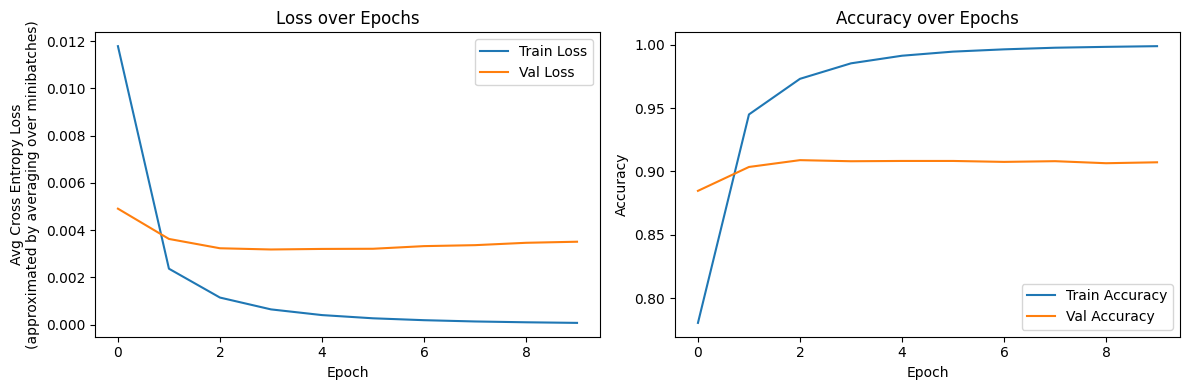

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss over Epochs
axs[0].plot(epoch_loss['train'], label='Train Loss')
axs[0].plot(epoch_loss['val'], label='Val Loss')
axs[0].legend()
axs[0].set_title('Loss over Epochs')
axs[0].set_ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
axs[0].set_xlabel('Epoch')

# Plot Accuracy over Epochs
axs[1].plot(epoch_acc['train'], label='Train Accuracy')
axs[1].plot(epoch_acc['val'], label='Val Accuracy')
axs[1].legend()
axs[1].set_title('Accuracy over Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Epoch')

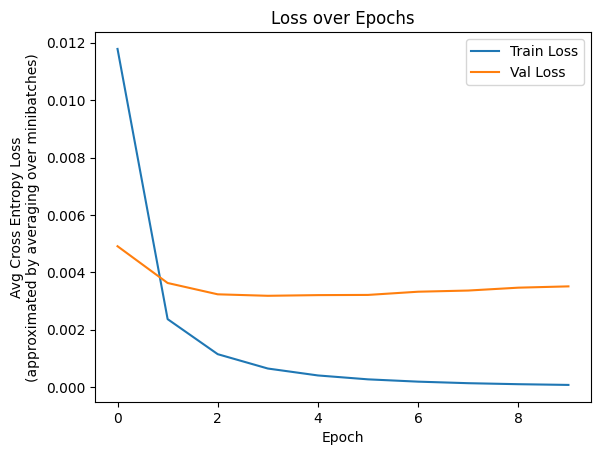

In [ ]:
plt.plot(epoch_loss['train'], label='Train Loss')
plt.plot(epoch_loss['val'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

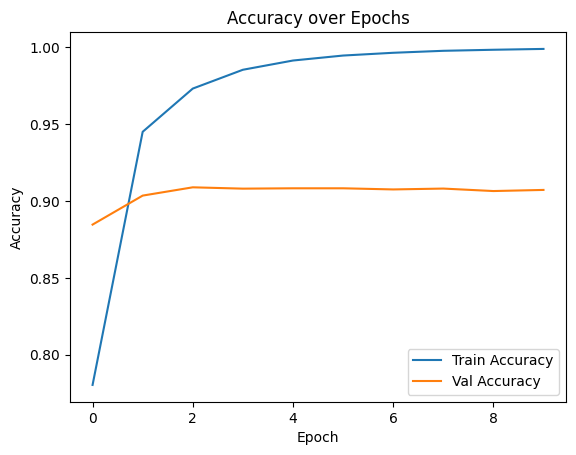

In [ ]:
plt.plot(epoch_acc['train'], label='Train Accuracy')
plt.plot(epoch_acc['val'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

**Observation**: 
- softmax regression achieves the accuracy on the test dataset: `test.acc: 90.63%`
- after 4 epochs, the improvement in performance is small. To prevent potential overfitting, the model is selected after 4 epochs using the early stopping technique
- n-grams BoW feature representation yields quite meaning encoding of protein sequence


Next steps to do / experiment with:
- Increase complexity of the model (add more FC layers prior to softmax)
- Have better hand-crafted feature representations (longer feature vector, different encoding technique) of the protein sequence 
- Switch to sequence models (to learn features without applying domain knowledge)

In [ ]:
def predict(model, dataloader):

    model.eval() # Set the model in evaluation mode

    acc_total = 0.
    num_samples = 0.
    
    total_preds = [] # Keep the predictions
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            num_samples += inputs.size(0)

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            _, probas = model.forward(inputs)
            predictions = torch.argmax(probas, dim=1)
            total_preds.append(predictions.cpu().numpy())

            acc_total += torch.sum(predictions == labels).item()


    acc_total = acc_total / num_samples
    total_preds = np.concatenate(total_preds) # list of mini-batch preds -> single continuous array 

    return total_preds, acc_total

In [ ]:
test_predictions, test_acc = predict(model, test_loader)

In [ ]:
test_acc

0.9063007297498218

In [ ]:
test_predictions.shape

(65913,)

In [ ]:
test_df.shape

(65913, 9)

In [ ]:
test_df['softmaxreg_preds'] = test_predictions

In [ ]:
data_path

'/content/drive/MyDrive/colabProteinProject/data'

In [ ]:
test_df.to_csv('/content/drive/MyDrive/colabProteinProject/data/softmaxreg_preds.csv', index=False)

## Stack more FC layers prior to softmax regression

In [ ]:
class FCSoftmaxRegression(torch.nn.Module):
    """ Softmax regression module with two hidden layers (dims hardcoded) """

    def __init__(self, input_dim, output_dim):
        """
        Args:
            input_dim  (int): input vector size.
            output_dim (int): output vector size (number of classes).
        """
        super().__init__()
        # self.linear = torch.nn.Linear(input_dim, output_dim)

        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 256)
        self.fc3 = torch.nn.Linear(256, output_dim)

    def forward(self, x):
        # pass x through a parameterized linear transformation
        # y = self.linear(x)

        x = self.fc1(x)
        x = torch.nn.functional.relu(x)

        # pass through second hidden layer
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)

        # pass through the third (output) layer
        x = self.fc3(x)


        # pass the result through softmax over the last dimension to generate
        # a probability distribution vector over the classes:
        y = torch.nn.functional.softmax(x, dim=-1)
        return y

In [ ]:
# Creating the model and moving it to the GPU (if available):
model = FCSoftmaxRegression(size_vocabulary, num_classes)
model.to(device)

FCSoftmaxRegression(
  (fc1): Linear(in_features=23, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=896, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 
                             weight_decay=0.001
                             )

In [ ]:
max_epochs = 30

for epoch in range(max_epochs):
    train_loss_total, train_acc_total = train(model, train_loader, loss_fn, optimizer)
    val_loss_total, val_acc_total = evaluate(model, dev_loader, loss_fn, optimizer)

    print(f'[EPOCH:{epoch+1:3d}/{max_epochs}]',
        f'train.loss: {train_loss_total:.4f}',
        f'train.acc: {100*train_acc_total:3.2f}%',
        f'val.loss: {val_loss_total:.4f}',
        f'val.acc: {100*val_acc_total:3.2f}%')

[EPOCH:  1/30] train.loss: 0.0526 train.acc: 7.52% val.loss: 0.0525 val.acc: 8.77%
[EPOCH:  2/30] train.loss: 0.0524 train.acc: 9.09% val.loss: 0.0524 val.acc: 9.50%
[EPOCH:  3/30] train.loss: 0.0524 train.acc: 9.49% val.loss: 0.0524 val.acc: 9.86%
[EPOCH:  4/30] train.loss: 0.0524 train.acc: 9.88% val.loss: 0.0524 val.acc: 10.08%
[EPOCH:  5/30] train.loss: 0.0523 train.acc: 10.30% val.loss: 0.0524 val.acc: 10.49%
[EPOCH:  6/30] train.loss: 0.0523 train.acc: 10.69% val.loss: 0.0523 val.acc: 10.94%
[EPOCH:  7/30] train.loss: 0.0523 train.acc: 10.86% val.loss: 0.0523 val.acc: 10.99%
[EPOCH:  8/30] train.loss: 0.0523 train.acc: 11.04% val.loss: 0.0523 val.acc: 11.18%
[EPOCH:  9/30] train.loss: 0.0523 train.acc: 11.19% val.loss: 0.0523 val.acc: 11.29%
[EPOCH: 10/30] train.loss: 0.0522 train.acc: 11.26% val.loss: 0.0523 val.acc: 11.22%
[EPOCH: 11/30] train.loss: 0.0522 train.acc: 11.34% val.loss: 0.0523 val.acc: 11.33%
[EPOCH: 12/30] train.loss: 0.0522 train.acc: 11.41% val.loss: 0.0523 val

In [ ]:
test_loss_total, test_acc_total = evaluate(model, test_loader, loss_fn, optimizer)

print(f'[Test set performance]',
        f'test.loss: {test_loss_total:.4f}',
        f'test.acc: {100*test_acc_total:3.2f}%')

[Test set performance] test.loss: 0.0522 test.acc: 11.69%


**Observation**: Increasing the model complexity has marginally helped with underfitting problem by increasing accuracy by 2-3%. 

Hence, to further improve the performance, more complex models can be used over BoW encoding or other known encoding techniques.  

Potential improvements:
- Use another technique for encoding the protein sequence, e.g. 2-gram BoW, 3-gram BoW, (combination of both)
- Use deeper NN (potentially add regularization: L2, dropout)
- Hyperparameter tuning, e.g. the default learning rate used (no tuning)

In [ ]:
lr = optimizer.param_groups[0]['lr']
lr

0.001

## Generate Predictions

In [ ]:
model.eval()

acc_total = 0.

# Keep test predictions
test_preds = np.empty((0,), dtype=np.int64)

for inputs, labels in test_loader:
    
    preds = model(inputs.to(device)).detach()
    acc_total += float(
        (torch.argmax(preds, dim=-1) == labels.to(preds.device)).sum()
    )

    preds = torch.argmax(preds, dim=-1).cpu().numpy()  # convert to numpy array
    test_preds = np.concatenate([test_preds, preds])


acc_total = acc_total / (len(test_ds))

In [ ]:
acc_total

0.11689329958108381

## Save results

In [ ]:
test_df['softmaxreg_preds'] = test_preds

In [ ]:
test_df.to_csv('/content/drive/MyDrive/instaDeep/data/softmaxreg_preds.csv', index=False)